<font size="5">Importing Libraries</font>

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix , roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from scipy.stats import randin
import xgboost
from xgboost import XGBClassifier

<font size="5">Reading Data from Train File and Basic Preprocessing</font>

In [150]:
train_data = []
with open("train.dat", "r") as train_file:
  train_data = train_file.readlines()

In [151]:
train_labels = []
train_features = []
for i in train_data:
  train_labels.append(int(i.split('\t')[0]))
  train_features.append(i.split('\t')[1])

In [152]:
train_df = pd.DataFrame()
trainLabels_df = pd.DataFrame()
train_df['features'] = train_features
trainLabels_df['labels'] = train_labels

In [153]:
train_df = train_df.features.str.split(expand=True).astype(float)
train_df.apply(lambda x: x.replace(np.NaN, 0, inplace = True))
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,6051,6052,6053,6054,6055,6056,6057,6058,6059,6060
0,191.0,367.0,614.0,634.0,711.0,1202.0,1220.0,1311.0,1472.0,1730.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,118.0,307.0,367.0,478.0,505.0,512.0,807.0,878.0,939.0,1024.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.0,184.0,284.0,297.0,320.0,375.0,445.0,588.0,658.0,1108.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,87.0,149.0,433.0,704.0,711.0,892.0,988.0,1056.0,1070.0,1234.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,84.0,118.0,279.0,316.0,435.0,505.0,584.0,629.0,849.0,1029.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<font size="5">Creating Sparse Matrix for Train Data Set </font>

In [154]:
td = train_df.to_numpy()
sparse_train_matrix = [[0 for i in range(100000)] for j in range(800)] 
for i in range(800):
  for j in range(6061):
    x = int(td[i][j])
    if x is not 0:
      sparse_train_matrix[i][x-1] = 1

<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-154-ec97b45ca246>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if x is not 0:


In [155]:
train_sparse_df = pd.DataFrame(sparse_train_matrix)
train_sparse_df.head()

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [164]:
train_sparse_df = np.array(sparse_train_matrix)
train_sparse_df.shape

(800, 100000)

<font size="5">Reading Data from Test File and Basic Preprocessing</font>

In [165]:
test_data = []
with open("test.dat", "r") as test_file:
  test_data = test_file.readlines()

In [166]:
test_df = pd.DataFrame()
test_df['features'] = test_data
test_df.head()

,features
0,354 386 517 627 646 764 870 915 1364 1502 1731...
1,23 225 360 394 433 445 1021 1205 1861 2036 208...
2,103 144 284 309 393 843 915 936 983 1183 1350 ...
3,13 174 300 307 430 523 546 616 861 1108 1117 1...
4,585 767 783 1176 1214 1224 1256 1303 1605 2102...


In [167]:
test_df = test_df['features'].str.split(expand=True).astype(float)
test_df.apply(lambda x: x.replace(np.NaN, 0, inplace = True))
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4847,4848,4849,4850,4851,4852,4853,4854,4855,4856
0,354.0,386.0,517.0,627.0,646.0,764.0,870.0,915.0,1364.0,1502.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23.0,225.0,360.0,394.0,433.0,445.0,1021.0,1205.0,1861.0,2036.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,103.0,144.0,284.0,309.0,393.0,843.0,915.0,936.0,983.0,1183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13.0,174.0,300.0,307.0,430.0,523.0,546.0,616.0,861.0,1108.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,585.0,767.0,783.0,1176.0,1214.0,1224.0,1256.0,1303.0,1605.0,2102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<font size="5">Creating Sparse Matrix for Test Data Set </font>

In [215]:
sparse_test_matrix = [[0 for x in range(100000)] for y in range(350)]
for i in range(350):
  for j in range(4857):
    x = int(test_df[i][j])
    if x is not 0:
      sparse_test_matrix[i][x-1] = 1

<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-215-c4c022c07183>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if x is not 0:


In [216]:
test_sparse_df = pd.DataFrame(sparse_test_matrix)

<font size="5">Balancing Data imbalance using Smote-Tomec</font>

In [173]:
# sm = SMOTE(random_state=42,kind='svm')
# reduced_features, labels = sm.fit_sample(reduced_features, labels)

<font size="5">Feature Selection: SVD</font>

In [174]:
svd_instance = TruncatedSVD(algorithm='randomized', n_components=800, n_iter=50, random_state=42)
svd = svd_instance.fit(train_sparse_df, trainLabels_df)
train_svd = svd.transform(train_sparse_df)

In [175]:
pd.DataFrame(train_svd).head()

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,4.209866,-0.733075,-1.570752,-0.766397,-0.393438,0.175756,0.265072,0.055903,0.468170,-0.161659,...,0.271762,-0.571365,-0.434348,0.350460,-1.675651,0.073089,0.301416,0.029130,-1.115207,1.057512
1,3.864993,-0.452234,-1.629992,-1.057283,-0.210888,-0.019759,0.274282,-0.045534,0.042677,-0.043942,...,-0.263202,2.533338,-0.065902,0.010651,-0.153385,1.523213,-0.665576,-1.098252,-1.519661,-1.041647
2,3.767743,-0.568984,-1.656248,-0.999098,-0.223674,0.103720,0.485973,0.119731,0.177672,-0.139598,...,1.358940,0.780513,0.126284,0.047748,1.430632,0.019129,-1.060616,-0.760787,-0.449512,-1.703933
3,3.895825,-0.485487,-1.733745,-0.907969,-0.307753,-0.088896,0.671033,-0.141934,0.011025,0.076621,...,1.272386,2.516159,-0.041876,0.826883,0.879549,-1.138676,-1.049456,-1.259871,0.125262,-1.031144
4,3.881688,-0.209835,-1.515436,-0.900967,-0.206142,0.018235,0.451900,0.097368,0.044001,-0.103369,...,-1.741662,-0.127360,0.996954,0.499876,0.452512,-0.211526,-0.145132,0.082420,-0.034287,0.572985


In [176]:
var_explained = svd.explained_variance_ratio_.sum()

In [177]:
print(var_explained)

0.999999999999998


In [203]:
test_svd = svd_instance.fit_transform(test_sparse_df)

In [204]:
test_svd = pd.DataFrame(test_svd).head()

In [205]:
test_svd.shape

(5, 350)

<font size="5">Feature Selection : PCA</font>

In [206]:
# pca = PCA(n_components = 500, random_state=1234,svd_solver="auto")
# x_pca = pca.fit_transform(train_df)
# x_pca.shape
# np.sum((pca.explained_variance_ratio_))
# data = pd.DataFrame(x_reduced)
# data.head()

<font size="5"> Splitting Data into Train and Test set</font>

In [207]:
X_train , X_test, y_train, y_test = train_test_split(train_svd, trainLabels_df, random_state=42, test_size=0.2)

<font size="5"> Decision Tree</font>

In [208]:
dtc = DecisionTreeClassifier(class_weight={0: 1, 1: 3}, random_state = 42)
dtc.fit(X_train , y_train)
y_hat = dtc.predict(X_test)

In [209]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       144
           1       0.57      0.50      0.53        16

    accuracy                           0.91       160
   macro avg       0.76      0.73      0.74       160
weighted avg       0.91      0.91      0.91       160



In [210]:
confusion_matrix(y_test,y_hat)

array([[138,   6],
       [  8,   8]])

In [211]:
y_predict_proba = dtc.predict_proba(X_test)[:,-1]
roc_auc_score(y_test,y_predict_proba)

0.7291666666666666

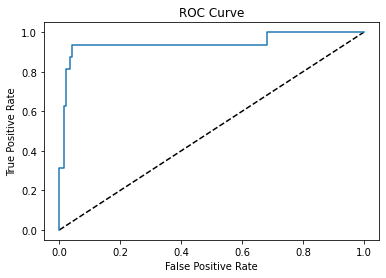

In [212]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

<font size="5"> Hyperparameter tuning using RandomizedSearchCV </font>

In [139]:
param_dist = {"max_depth":[0,16],
              "min_samples_leaf": randint(1, 1000),
              "criterion": ["gini", "entropy"]}
tree_cv = RandomizedSearchCV(dtc, param_dist, cv=5)
tree_cv.fit(X_train,y_train)
y_hat = tree_cv.predict(X_test)
print(classification_report(y_test,y_hat))
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       144
           1       0.00      0.00      0.00        16

    accuracy                           0.90       160
   macro avg       0.45      0.50      0.47       160
weighted avg       0.81      0.90      0.85       160

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 213}
Best score is 0.903125


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 306, in fit
    raise ValueError("max_depth must be greater than zero. ")
ValueError: max_d

In [140]:
y_predict_proba = tree_cv.predict_proba(X_test)[:,-1]
roc_auc_score(y_test,y_predict_proba)

0.7825520833333333

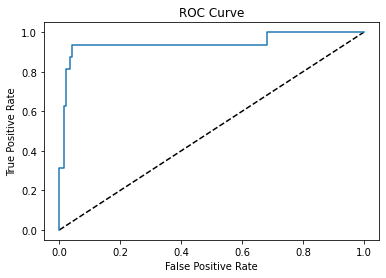

In [141]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [40]:
# testFile=open('output.txt','w')
# for element in y_hat:
#         if element == 0:
#             testFile.write('0')
#         else:
#             testFile.write('1')
#         testFile.write('\n')
# testFile.close()

<font size="5">  Knn  </font>

In [135]:
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train,y_train)
y_hat = knn.predict(X_test)

In [136]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       144
           1       0.00      0.00      0.00        16

    accuracy                           0.90       160
   macro avg       0.45      0.50      0.47       160
weighted avg       0.81      0.90      0.85       160



/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [137]:
y_predict_proba = knn.predict_proba(X_test)[:,-1]
roc_auc_score(y_test,y_predict_proba)

0.8559027777777777

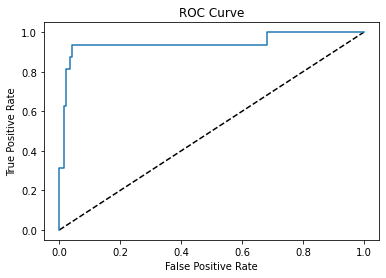

In [138]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [46]:
# testFile=open('output.txt','w')
# for element in y_hat:
#         if element == 0:
#             testFile.write('0')
#         else:
#             testFile.write('1')
#         testFile.write('\n')
# testFile.close()

<font size="5"> RandomForest</font>

In [126]:
rfc = RandomForestClassifier(n_estimators=500,oob_score=True)

In [127]:
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=500, oob_score=True)

In [128]:
y_hat = rfc.predict(X_test)

In [129]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       144
           1       0.75      0.19      0.30        16

    accuracy                           0.91       160
   macro avg       0.83      0.59      0.63       160
weighted avg       0.90      0.91      0.89       160



In [130]:
rfc.oob_score_

0.9109375

In [133]:
y_predict_proba = rfc.predict_proba(X_test)[:,-1]
roc_auc_score(y_test,y_predict_proba)

0.9290364583333334

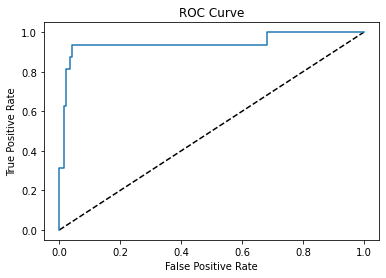

In [134]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [121]:
adbc = AdaBoostClassifier(n_estimators=500,random_state=42)
adbc.fit(X_train,y_train)
y_hat = adbc.predict(X_test)

In [122]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       144
           1       0.83      0.62      0.71        16

    accuracy                           0.95       160
   macro avg       0.90      0.81      0.84       160
weighted avg       0.95      0.95      0.95       160



In [123]:
y_predict_proba = adbc.predict_proba(X_test)[:,-1]
roc_auc_score(y_test,y_predict_proba)

0.9418402777777778

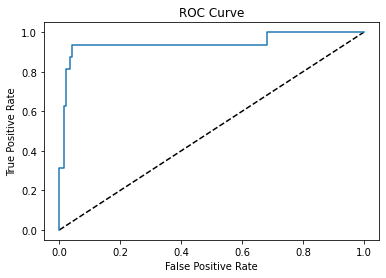

In [124]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

<font size="5"> XGBoost</font>

In [56]:
# xgbc = XGBClassifier()
# xgbc.fit(X_train, y_train)
# y_hat = xgbc.predict(X_test)

NameError: name 'XGBClassifier' is not defined

In [ ]:
print(classification_report(y_test,y_hat))

<font size="5"> SVM</font>

In [117]:
clf = SVC(kernel='linear', class_weight={0: 1, 1: 3}, random_state = 42)
clf.fit(X_train,y_train)
y_hat = clf.predict(X_test)

In [118]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96       144
           1       0.80      0.25      0.38        16

    accuracy                           0.92       160
   macro avg       0.86      0.62      0.67       160
weighted avg       0.91      0.92      0.90       160



In [119]:
confusion_matrix(y_test,y_hat)

array([[143,   1],
       [ 12,   4]])

<font size="5">Logistic Regression</font>

In [93]:
logreg = LogisticRegression(solver = 'saga',random_state = 42 , penalty = 'l1')
logreg.fit(X_train,y_train)
y_hat = logreg.predict(X_test)

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [94]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       144
           1       0.83      0.31      0.45        16

    accuracy                           0.93       160
   macro avg       0.88      0.65      0.71       160
weighted avg       0.92      0.93      0.91       160



In [95]:
confusion_matrix(y_test,y_hat)

array([[143,   1],
       [ 11,   5]])

In [147]:
y_predict_proba = logreg.predict_proba(X_test)[:,-1]
roc_auc_score(y_test,y_predict_proba)

0.9444444444444444

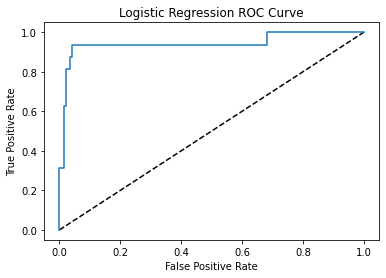

In [148]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

<font size="5">Use this to run any classifer on test data </font>

In [ ]:
# y_pred = "Add classfier here".predict(test_svd)
# testFile=open('output.txt','w')
# for element in y_hat:
#         if element == 0:
#             testFile.write('0')
#         else:
#             testFile.write('1')
#         testFile.write('\n')
# testFile.close()